**Задание**  

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров.

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

1. Cформулируем гипотезы для проверки:
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [13]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-na-t/Statistics/experiment_lesson_4.csv')
df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


2. Построим графики распределения по тестовой и контрольной группе.

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

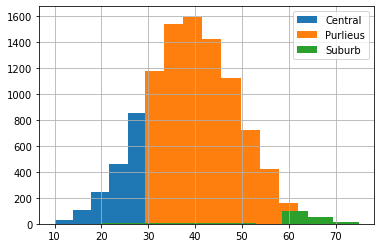

In [26]:
df1 = df.query('experiment_group=="test"').groupby('district').delivery_time
df1.hist(legend=True)

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

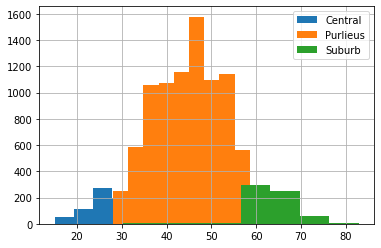

In [27]:
df2 = df.query('experiment_group=="control"').groupby('district').delivery_time
df2.hist(legend=True)

3. Посчитаем количество наблюдений в тестовой и контрольной группе. 

In [33]:
df.groupby('experiment_group').agg({'order_id':'count'})

,order_id
experiment_group,
control,10092
test,10104


In [38]:
df.groupby('experiment_group').agg({'order_id':'count'}).order_id[0] - df.groupby('experiment_group').agg({'order_id':'count'}).order_id[1]

-12

Изучим распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.
При этом, для выборок малых размеров не обязательно это делать, т.к. в отсутствие выраженной асимметрии и выбросов в данных t-тест и так будет нормально работать. 
Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности. Поэтому используем функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам.

4. Для того, чтобы проверить нормальность распределения, используем тест Агостино-Пирсона по функции scipy.stats.normaltest().

In [46]:
import scipy as scipy
scipy.stats.normaltest(df.query('experiment_group=="test"').delivery_time)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [47]:
scipy.stats.normaltest(df.query('experiment_group=="control"').delivery_time)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [51]:
df.query('experiment_group=="test"').delivery_time.std()

9.883308351129061

In [52]:
df.query('experiment_group=="control"').delivery_time.std()

9.990016960246372

Вывод:
- Этот тест показывает, что значения в тестовой группе распределены НЕНОРМАЛЬНО
- В контрольной группе распределение является НОРМАЛЬНЫМ
- Стандартное отклонение времени доставки в тесте равно 9.88
- Стандартное отклонение времени доставки в контроле равно 9.99

5. Сравним средние в тестовой и контрольной группе. Для сравнения средних в данных экспериментальных группах я использую 
STUDENT'S T-TEST

In [53]:
test = df.query('experiment_group=="test"').delivery_time
control = df.query('experiment_group=="control"').delivery_time

In [61]:
(test.mean()-control.mean())/(test.std()/test.count()**0.5 + control.std()/control.count()**0.5)

-30.43121922127618

In [63]:
#Тест Стьюдента
scipy.stats.ttest_ind(test, control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Вывод: Статистика в тесте равна -43, p-value <= 0.05.

In [67]:
#Среднее время доставки снизилось на 13.35% в тестовой группе по сравнению с контрольной.
((test.mean()-control.mean())/control.mean()*100).round(2)

-13.35

Вывод по Заданию:  
Да, новый алгоритм рекомендуется раскатить на всех пользователей, так как среднее время доставки статистически значимо изменилось.   
Среднее время доставки в тесте меньше, чем в контроле на 13.35%.